In [117]:
#import the libraries
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from lmfit import minimize, Parameters, Parameter, report_fit
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
from sklearn.metrics import r2_score

In [93]:
#read the experimental data
data = pd.read_csv("data.csv")
display(data)

#Define the time range of integration
t = data.iloc[:,0]

#Define experimental data
Xexp = data.iloc[:,1]
Sexp = data.iloc[:,2]
Pexp = data.iloc[:,3]

,t(h),X,S,P
0,0,1.70,91.45,0.87
1,1,1.65,89.74,1.77
2,2,1.85,87.94,2.03
3,3,2.80,81.84,4.05
4,4,2.65,74.64,8.18
5,5,3.35,65.85,12.80
6,6,3.30,55.23,15.38
7,7,5.05,45.54,21.10
8,8,4.17,37.96,28.06
9,9,3.90,28.66,33.22


In [94]:
#Definition of kinetic model (Monod)
def monod(z,t,paras):
    #Conversion parameters (experimental)
    Yxs = 0.0434
    Yps = 0.5078
    Ypx = Yps/Yxs

    #Assign each variable to a vector z
    X = z[0]
    S = z[1]
    P = z[2]

    try:
        umax = paras['umax'].value
        Ks   = paras['Ks'].value

    except KeyError:
        umax, Ks = paras

    #Define the ODE system
    dXdt = umax*S/(Ks+S)*X
    dSdt = -umax*S/(Ks+S)*X/Yxs
    dPdt = umax*S/(Ks+S)*X*Ypx
   
    return [dXdt,dSdt,dPdt]

In [95]:
#Define odeint to solve the model
def solver(t,x0,paras):
    x = odeint(monod,x0,t, args=(paras,))
    return x

In [107]:
#Define objective function
def objFun(paras, t, Xexp, Sexp, Pexp):
    x0 = paras['X0'].value, paras['S0'].value, paras['P0'].value
    model = solver(t, x0, paras)
    X_model = model[:, 0]
    S_model = model[:, 1]
    P_model = model[:, 2]
    return (((X_model - Xexp)**2+(P_model - Pexp)**2+(S_model - Sexp)**2)**0.5).ravel()

In [132]:
#Define initial conditions
X0 = data.iloc[0,1]
S0 = data.iloc[0,2]
P0 = data.iloc[0,3]
init = [X0, S0, P0]

# set parameters including bounds; you can also fix parameters (use vary=False)
params = Parameters()
params.add('X0', value=X0, vary=False)
params.add('S0', value=S0, vary=False)
params.add('P0', value=P0, vary=False)
params.add('umax', value=0.5, min=0.0001, max=1)
params.add('Ks', value=2, min=0.0001, max=10)

# fit model
result = minimize(objFun, params, args=(t, Xexp, Sexp, Pexp), method='leastsq')  # leastsq nelder

# results of the optimal fit
t2 = np.linspace(min(t),max(t),500)
fitted = solver(t2, init, result.params)
Xopt = fitted[:,0]
Sopt = fitted[:,1]
Popt = fitted[:,2]

# display fitted statistics
report_fit(result)



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 59
    # data points      = 13
    # variables        = 2
    chi-square         = 170.946701
    reduced chi-square = 15.5406092
    Akaike info crit   = 37.4932320
    Bayesian info crit = 38.6231307
[[Variables]]
    X0:    1.7 (fixed)
    S0:    91.45 (fixed)
    P0:    0.87 (fixed)
    umax:  0.10622090 +/- 0.00913552 (8.60%) (init = 0.5)
    Ks:    0.48016910 +/- 4.35015988 (905.96%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(umax, Ks) = 0.979


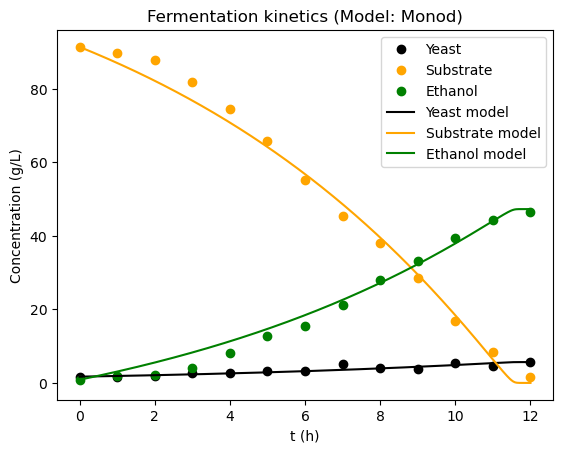

In [133]:
#Graphics
#Experimental points
plt.plot(t, Xexp, 'o', color='black', label = 'Yeast')
plt.plot(t, Sexp, 'o', color='orange',label = 'Substrate')
plt.plot(t, Pexp, 'o', color='green', label = 'Ethanol')

#ODE system model
plt.plot(t2, Xopt,'-', color='black', label = 'Yeast model')
plt.plot(t2, Sopt,'-', color='orange',label = 'Substrate model')
plt.plot(t2, Popt,'-', color='green', label = 'Ethanol model')

#Graphic parameters
plt.title('Fermentation kinetics (Model: Monod)')
plt.xlabel('t (h)')
plt.ylabel('Concentration (g/L)')
plt.legend(loc='best')

Text(0.5, 1.0, 'Estimated vs. observed (Ethanol)')

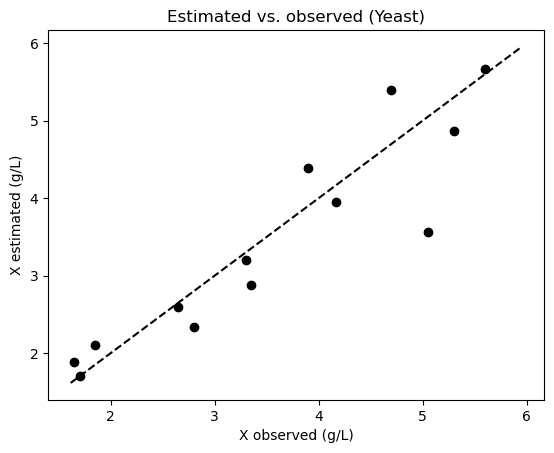

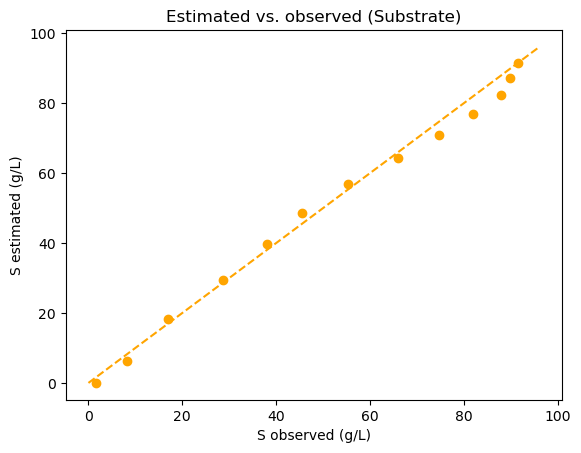

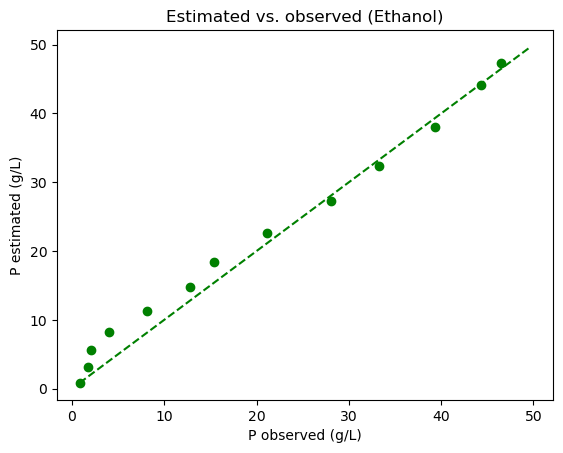

In [106]:
#Estimated vs. observed plots

#Yeast
plt.figure(0)
plt.plot(Xexp, Xopt, 'o', color='black')
plt.plot([min(Xopt)*0.95,max(Xopt)*1.05], [min(Xopt)*0.95,max(Xopt)*1.05], '--', color='black')
#Graphic parameters
plt.xlabel('X observed (g/L)')
plt.ylabel('X estimated (g/L)')
plt.title("Estimated vs. observed (Yeast)")

#Substrate
plt.figure(1)
plt.plot(Sexp, Sopt, 'o', color='orange')
plt.plot([min(Sopt)*0.95,max(Sopt)*1.05], [min(Sopt)*0.95,max(Sopt)*1.05], '--', color='orange')
#Graphic parameters
plt.xlabel('S observed (g/L)')
plt.ylabel('S estimated (g/L)')
plt.title("Estimated vs. observed (Substrate)")

#Product (Ethanol)
plt.figure(2)
plt.plot(Pexp, Popt, 'o', color='green')
plt.plot([min(Popt)*0.95,max(Popt)*1.05], [min(Popt)*0.95,max(Popt)*1.05], '--', color='green')
#Graphic parameters
plt.xlabel('P observed (g/L)')
plt.ylabel('P estimated (g/L)')
plt.title("Estimated vs. observed (Ethanol)")

In [120]:
#Statistics
print("X: R² = {:.3f}".format(r2_score(Xexp,Xopt)))
print("S: R² = {:.3f}".format(r2_score(Sexp,Sopt)))
print("P: R² = {:.3f}".format(r2_score(Pexp,Popt)))

X: R² = 0.835
S: R² = 0.991
P: R² = 0.982


In [100]:
#Calculate the residues from optimized model and experimental data
resX = Xexp - Xopt
resS = Sexp - Sopt
resP = Pexp - Popt


The residues of X are normally distributed. p-value = 0.233 > 0.01
The residues of S are normally distributed. p-value = 0.598 > 0.01
The residues of P are normally distributed. p-value = 0.513 > 0.01


Text(0.5, 0, 'Residues P')

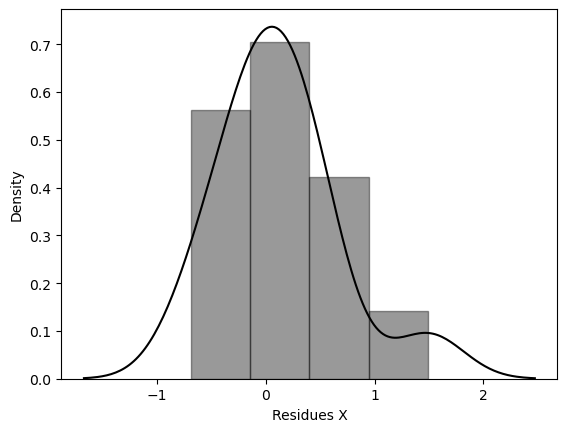

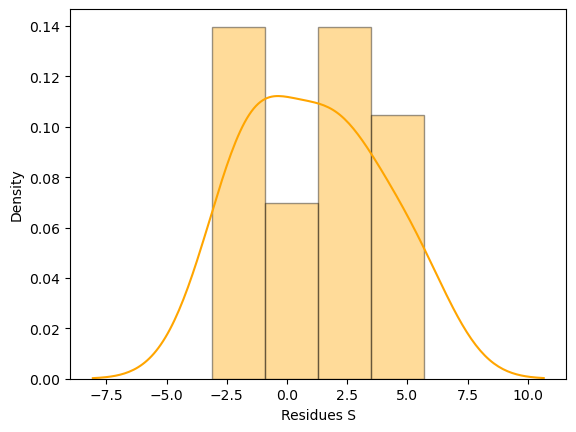

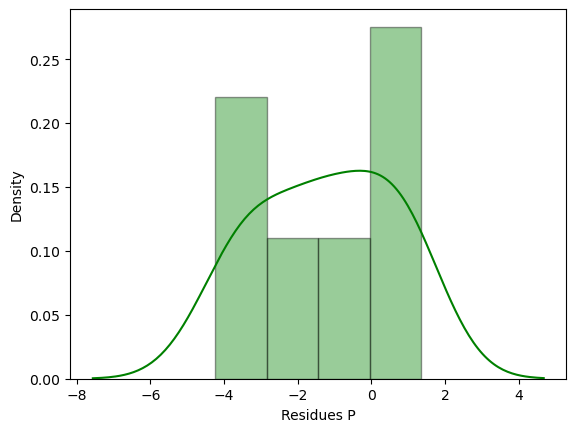

In [101]:
#Histogram residues
warnings.filterwarnings('ignore')

#Specify the confidence level
alfa = 0.01

#plot the residues of X and test normality
plt.figure(4)
sns.distplot(resX, hist = True, kde = True, bins = 4, color = 'black', hist_kws={'edgecolor': 'black'})
hX = stats.shapiro(resX)
if hX[1] < alfa:
    print('The residues of X are not normally distributed. p-value = {:.3f} < {:.2f}'.format(hX[1],alfa))
else:
    print('The residues of X are normally distributed. p-value = {:.3f} > {:.2f}'.format(hX[1],alfa))

plt.xlabel('Residues X')

#plot the residues of S and test normality
plt.figure(5)
sns.distplot(resS, hist = True, kde = True, bins = 4, color = 'orange', hist_kws={'edgecolor': 'black'})
hS = stats.shapiro(resS)
if hS[1] < alfa:
    print('The residues of S are not normally distributed. p-value = {:.3f} < {:.2f}'.format(hS[1],alfa))
else:
    print('The residues of S are normally distributed. p-value = {:.3f} > {:.2f}'.format(hS[1],alfa))
plt.xlabel('Residues S')

#plot the residues of P and test normality
plt.figure(6)
sns.distplot(resP, hist = True, kde = True, bins = 4, color = 'green', hist_kws={'edgecolor': 'black'})
hP = stats.shapiro(resP)
if hP[1] < alfa:
    print('The residues of P are not normally distributed. p-value = {:.3f} < {:.2f}'.format(hP[1],alfa))
else:
    print('The residues of P are normally distributed. p-value = {:.3f} > {:.2f}'.format(hP[1],alfa))
plt.xlabel('Residues P')


Text(0.5, 1.0, 'Residues vs. estimated (Ethanol)')

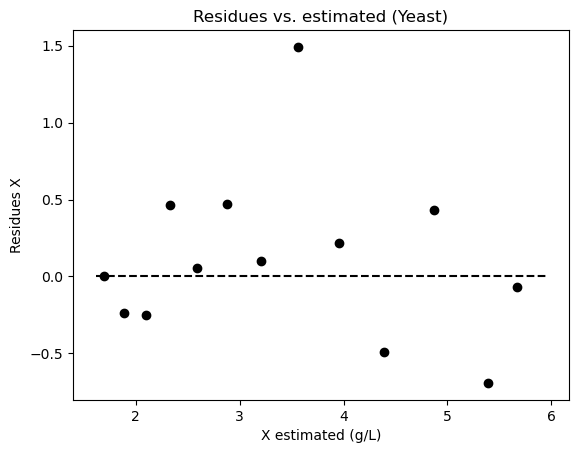

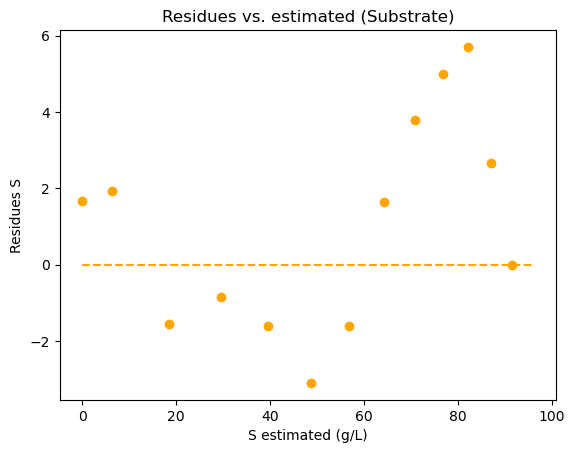

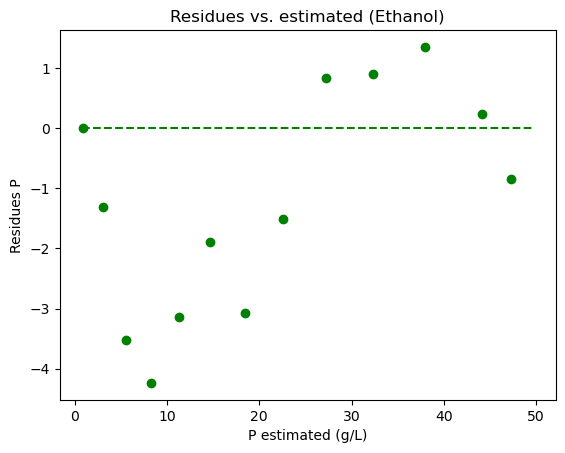

In [104]:
#Residues vs. estimated plots

#Yeast
plt.figure(3)
plt.plot(Xopt,resX, 'o', color='black')
plt.plot([min(Xopt)*0.95,max(Xopt)*1.05], [0,0], '--', color='black')
#Graphic parameters
plt.xlabel('X estimated (g/L)')
plt.ylabel('Residues X')
plt.title("Residues vs. estimated (Yeast)")

#Substrate
plt.figure(4)
plt.plot(Sopt,resS, 'o', color='orange')
plt.plot([min(Sopt)*0.95,max(Sopt)*1.05], [0,0], '--', color='orange')
#Graphic parameters
plt.xlabel('S estimated (g/L)')
plt.ylabel('Residues S')
plt.title("Residues vs. estimated (Substrate)")

#Product (Ethanol)
plt.figure(5)
plt.plot(Popt,resP, 'o', color='green')
plt.plot([min(Popt)*0.95,max(Popt)*1.05], [0,0], '--', color='green')
#Graphic parameters
plt.xlabel('P estimated (g/L)')
plt.ylabel('Residues P')
plt.title("Residues vs. estimated (Ethanol)")